In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error


In [13]:
# =======================
# 1. Load dataset
# =======================
diabetes = datasets.load_diabetes()
X = diabetes.data
Y = diabetes.target

feature_names = diabetes.feature_names

In [14]:
# =======================
# 2. Train/Validation/Test split
# =======================
X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

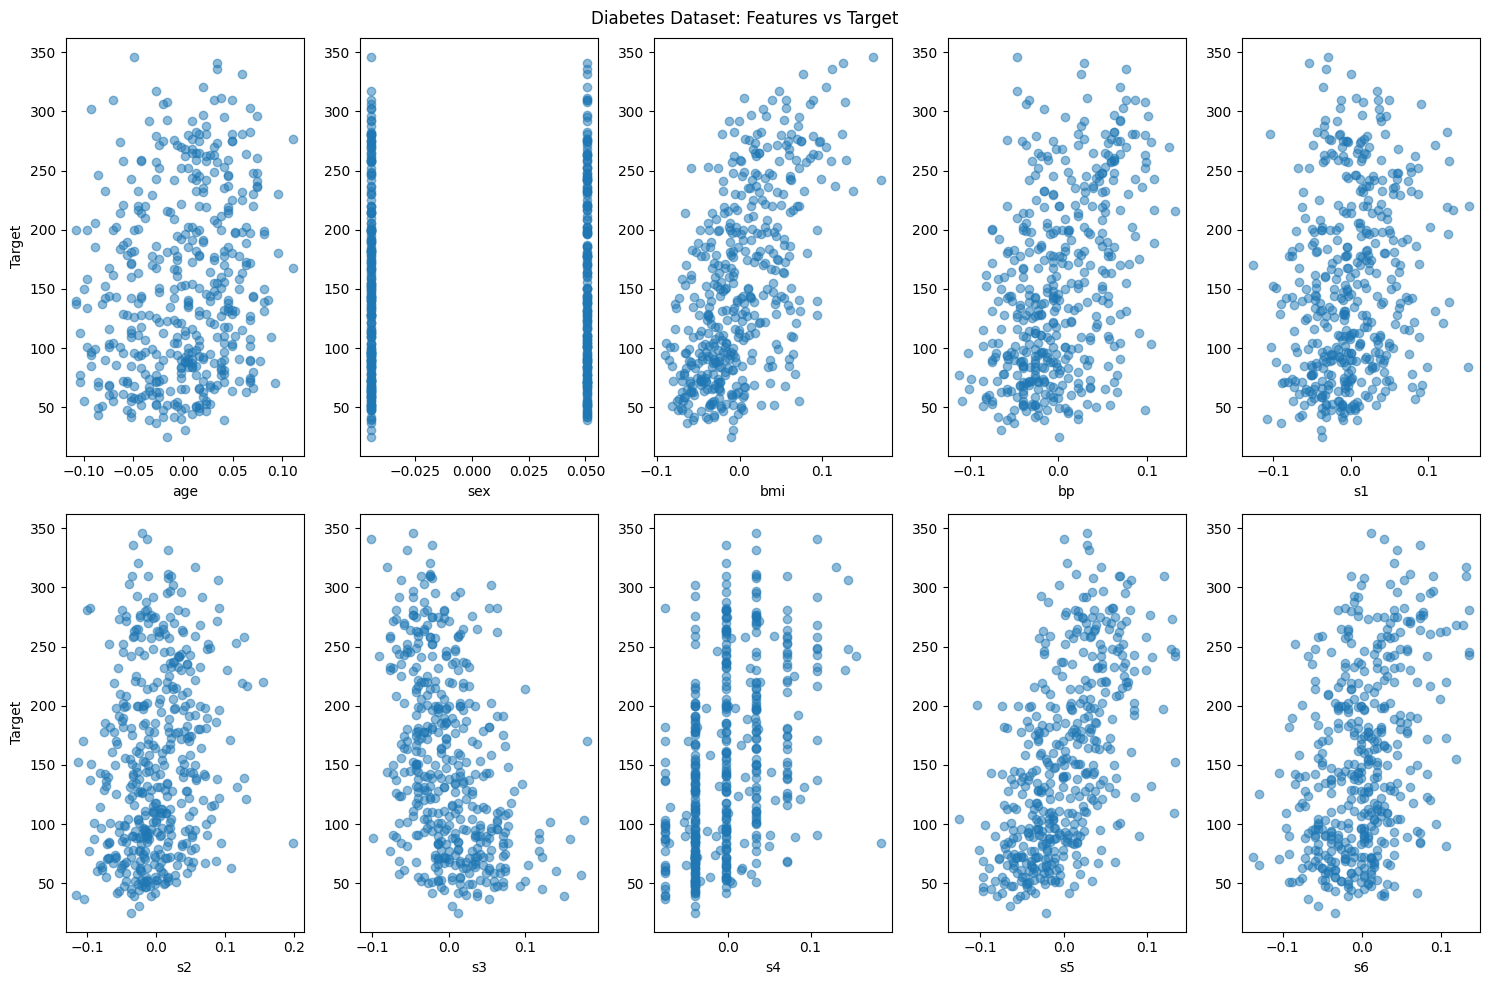

In [16]:
# =======================
# 3. Visualize the data
# =======================

# Scatter plots for each feature vs target

plt.figure(figsize=(15, 10))
for i in range(X.shape[1]):
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    plt.scatter(X[:, i], Y, alpha=0.5)
    plt.xlabel(feature_names[i])
    if i % 5 == 0:
        plt.ylabel("Target")
plt.suptitle("Diabetes Dataset: Features vs Target")
plt.tight_layout()
plt.show()

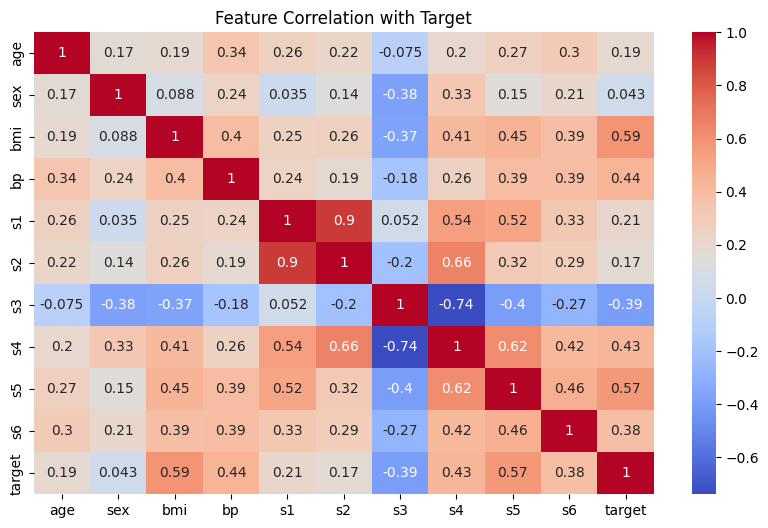

In [18]:
# Correlation heatmap (quick overview)

import seaborn as sns
import pandas as pd

df = pd.DataFrame(X, columns=feature_names)
df["target"] = Y

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation with Target")
plt.show()


In [19]:
# =======================
# 4. Scenario 1: Linear Regression with K-Fold CV
# =======================
lin_reg = LinearRegression()   # define a simple linear regression model
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # create 5-fold cross-validation splitter

linear_scores = cross_val_score(
    lin_reg, X_trainval, Y_trainval, cv=kf, scoring='neg_mean_squared_error'
)   # perform cross-validation and collect MSE scores (negative because of sklearn convention)
linear_mse = -linear_scores.mean()   # average MSE across folds (negated back to positive)
print("Scenario 1 - Linear Regression mean CV MSE:", linear_mse)

Scenario 1 - Linear Regression mean CV MSE: 3074.142063668879


In [20]:
# =======================
# 5. Scenario 2: Polynomial Regression with K-Fold CV
# =======================
# Let's test degree=2 for polynomial
poly_model = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),  # generate polynomial features (x, x^2)
    ("lin_reg", LinearRegression())  # apply linear regression on expanded features
])

poly_scores = cross_val_score(
    poly_model, X_trainval, Y_trainval, cv=kf, scoring='neg_mean_squared_error'
)   # perform cross-validation for polynomial regression
poly_mse = -poly_scores.mean()   # average MSE across folds
print("Scenario 2 - Polynomial Regression (degree=2) mean CV MSE:", poly_mse)

Scenario 2 - Polynomial Regression (degree=2) mean CV MSE: 3926.314380571428


In [21]:
# =======================
# 6. Choose the better model and evaluate on Test Set
# =======================
if poly_mse < linear_mse:
    print("Polynomial Regression performs better, evaluating on test set...")
    best_model = poly_model   # select polynomial regression as best
else:
    print("Linear Regression performs better, evaluating on test set...")
    best_model = lin_reg   # select linear regression as best

Linear Regression performs better, evaluating on test set...


In [25]:
# Train best model on full training+validation set
best_model.fit(X_trainval, Y_trainval)   # fit best model on all training+validation data
Y_pred = best_model.predict(X_test)     # predict on the held-out test set
test_mse = mean_squared_error(Y_test, Y_pred)  # evaluate using MSE on test set
print("Final Test MSE:", test_mse)

from sklearn.metrics import r2_score
print("R2 Score:", r2_score(Y_test, Y_pred))


Final Test MSE: 2900.193628493482
R2 Score: 0.4526027629719195


In [31]:
# Coefficients: actually the corresponding weight for each feature (w1, w2 ...)
# Intercept: the b parameter in Y = WX + b
print(diabetes.feature_names)
print('Coefficients:', best_model.coef_)
print('Intercept:', best_model.intercept_)

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
Coefficients: [  37.90402135 -241.96436231  542.42875852  347.70384391 -931.48884588
  518.06227698  163.41998299  275.31790158  736.1988589    48.67065743]
Intercept: 151.34560453985995


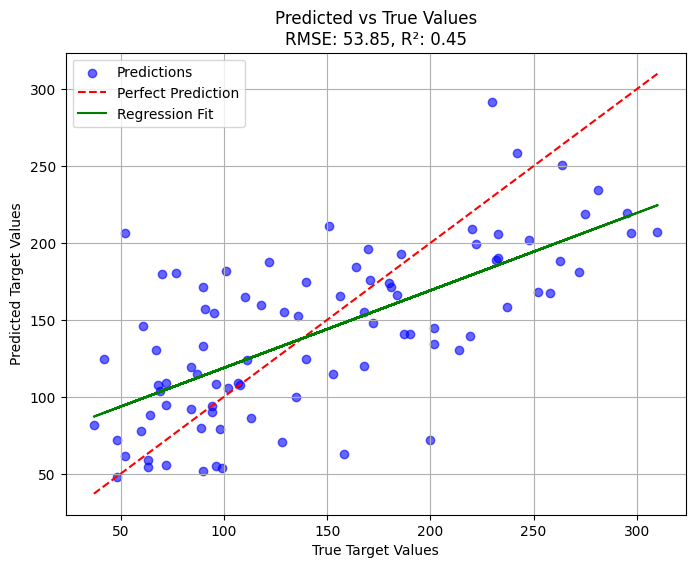

In [29]:
# =======================
# 7. Visualization of prediction vs actual
# =======================



import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import LinearRegression

# Compute metrics
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

# Fit a regression line through predicted vs actual
reg_line = LinearRegression()
Y_test_reshaped = Y_test.reshape(-1, 1)  # make it 2D for sklearn
reg_line.fit(Y_test_reshaped, Y_pred)
Y_fit = reg_line.predict(Y_test_reshaped)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred, color="blue", alpha=0.6, label="Predictions")
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()],
         color="red", linestyle="--", label="Perfect Prediction")
plt.plot(Y_test, Y_fit, color="green", linestyle="-", label="Regression Fit")
plt.xlabel("True Target Values")
plt.ylabel("Predicted Target Values")
plt.title(f"Predicted vs True Values\nRMSE: {rmse:.2f}, R²: {r2:.2f}")
plt.legend()
plt.grid(True)
plt.show()
